## Set Up Environment

In [ ]:
%%capture
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

!pip install matplotlib pandas pillow torchtnt==0.2.0 tqdm tabulate

!pip install distinctipy

!pip install cjm_pandas_utils cjm_psl_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms

!pip install wandb onnx -Uq

## Import Dependencies

In [ ]:
import datetime
from functools import partial
from glob import glob
import json
import math
import multiprocessing
import json
import os
from pathlib import Path
import random
from typing import Any, Dict, Optional

from cjm_psl_utils.core import download_file, file_extract, get_source_code
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, get_torch_device, set_seed, denorm_img_tensor, move_data_to_device
from cjm_pandas_utils.core import markdown_to_pandas, convert_to_numeric, convert_to_string
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

from distinctipy import distinctipy

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

from PIL import Image, ImageDraw

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, jaccard_score

import torch
from torch.amp import autocast
from torch.cuda.amp import GradScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtnt.utils import get_module_summary
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from tqdm.auto import tqdm

import wandb

## Set Up Project

### Set Seed

In [ ]:
seed = 42
set_seed(seed)

### Wandb Login

In [ ]:
wandb.login()

### Set the Device and Data Type

In [ ]:
device = get_torch_device()
dtype = torch.float32
device, dtype

('cuda', torch.float32)

### Setting the Directory Paths

In [ ]:
project_name = f"BrainTumor_Segmentation_MaskRCNN"
project_dir = Path(f"./{project_name}/")
project_dir.mkdir(parents=True, exist_ok=True)

dataset_dir = Path("./Datasets/")
dataset_dir.mkdir(parents=True, exist_ok=True)

pd.Series({
    "Project Directory:": project_dir,
    "Dataset Directory:": dataset_dir
}).to_frame().style.hide(axis='columns')

Project Directory:,BrainTumor_Segmentation_MaskRCNN
Dataset Directory:,Datasets


## Download, Transform, and Visualize the Dataset

### Setting the Dataset Path

In [ ]:
dataset_name = 'Brain-Tumor-Detection-Dataset'

gh_repo = f'AhmedHamada0/{dataset_name}'

dataset_path = Path(f'{dataset_dir}/{dataset_name}')
pd.Series({
    "GitHub Repository:": gh_repo,
    "Dataset Path:": dataset_path
}).to_frame().style.hide(axis='columns')

GitHub Repository:,AhmedHamada0/Brain-Tumor-Detection-Dataset
Dataset Path:,Datasets/Brain-Tumor-Detection-Dataset


### Downloading the Dataset

In [ ]:
!rm -rf /content/Datasets/Brain-Tumor-Detection-Dataset

In [ ]:
!git clone {f'https://github.com/{gh_repo}.git'} {dataset_path}

Cloning into 'Datasets/Brain-Tumor-Detection-Dataset'...
remote: Enumerating objects: 3124, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 3124 (delta 21), reused 35 (delta 16), pack-reused 3082
Receiving objects: 100% (3124/3124), 64.13 MiB | 20.49 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [ ]:
!git clone {f'https://github.com/{gh_repo}.git'} '/content/trash'

Cloning into '/content/trash'...
remote: Enumerating objects: 3124, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 3124 (delta 21), reused 35 (delta 16), pack-reused 3082
Receiving objects: 100% (3124/3124), 64.13 MiB | 31.98 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [ ]:
!rm -rf /content/Datasets/Brain-Tumor-Detection-Dataset/no
!rm -rf /content/Datasets/Brain-Tumor-Detection-Dataset/pred
!rm -rf /content/Datasets/Brain-Tumor-Detection-Dataset/yes

In [ ]:
ext_dataset_name = 'Br35H-Mask-RCNN'
dataset_path = Path(f'{dataset_dir}/{dataset_name}/{ext_dataset_name}')
pd.Series({
    "GitHub Repository:": gh_repo,
    "Dataset Path:": dataset_path
}).to_frame().style.hide(axis='columns')

GitHub Repository:,AhmedHamada0/Brain-Tumor-Detection-Dataset
Dataset Path:,Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN


### Convert to Labelme Json

In [ ]:
def convert_annotations_to_labelme(source_json_path, output_folder, dataset_dir):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    with open(source_json_path, 'r') as file:
        data = json.load(file)

    subdirs = ['TEST', 'TRAIN', 'VAL']

    for key, value in data.items():
        image_found = False
        for subdir in subdirs:
            image_path = Path(dataset_dir) / subdir / value["filename"]
            if image_path.exists():
                image_found = True
                break

        if not image_found:
            print(f"Image {value['filename']} not found in any of {subdirs}. Skipping...")
            continue

        with Image.open(image_path) as img:
            width, height = img.size

        labelme_format = {
            "version": "4.5.6",
            "flags": {},
            "shapes": [],
            "imagePath": value["filename"],
            "imageData": None,
            "imageHeight": height,
            "imageWidth": width
        }

        for region in value.get("regions", []):
            shape_attributes = region.get("shape_attributes", {})
            if "all_points_x" in shape_attributes and "all_points_y" in shape_attributes:
                labelme_shape = {
                    "label": "tumor",
                    "points": list(zip(shape_attributes["all_points_x"], shape_attributes["all_points_y"])),
                    "group_id": None,
                    "shape_type": "polygon",
                    "flags": {}
                }
                labelme_format["shapes"].append(labelme_shape)

        if labelme_format["shapes"]:
            output_file_path = os.path.join(output_folder, value["filename"].replace(".jpg", ".json"))

            with open(output_file_path, 'w') as output_file:
                json.dump(labelme_format, output_file, indent=4)

    print(f"Conversion complete. Valid annotations saved to {output_folder}.")

In [ ]:
!rm -rf /content/Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN/LabelmeJson

In [ ]:
labelme_jsons_path = '/content/Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN/LabelmeJson'
source = '/content/trash/Br35H-Mask-RCNN/annotations_all.json'
dataset_dir = '/content/Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN'
convert_annotations_to_labelme(source, labelme_jsons_path,dataset_dir)

Conversion complete. Valid annotations saved to /content/Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN/LabelmeJson.


In [ ]:
!rm /content/Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN/annotations_all.json
!rm /content/Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN/TEST/annotations_test.json
!rm /content/Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN/TRAIN/annotations_train.json
!rm /content/Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN/VAL/annotations_val.json

### Getting the Image and Annotation Files

In [ ]:
def get_img_files_with_annotations(dataset_path):
    dataset_path = Path(dataset_path)
    annotation_file_paths = sorted(list(dataset_path.glob('**/*.json')), key=lambda p: p.stem)

    annotation_stems = {path.stem for path in annotation_file_paths}

    img_extensions = ['.jpg']

    img_file_paths_with_json = sorted(
        [img_path for ext in img_extensions for img_path in dataset_path.glob(f'**/*{ext}')
         if img_path.stem in annotation_stems],
        key=lambda p: p.stem
    )

    paired_paths = [(img_path, next(ann_path for ann_path in annotation_file_paths if ann_path.stem == img_path.stem))
                    for img_path in img_file_paths_with_json]

    return [pair[0] for pair in paired_paths], [pair[1] for pair in paired_paths]


img_file_paths, annotation_file_paths  = get_img_files_with_annotations(dataset_path)

In [ ]:
len(img_file_paths), len(annotation_file_paths)

(637, 637)

In [ ]:
pd.DataFrame({"Image File":img_file_paths,
              "Annotation File":annotation_file_paths}).head()

,Image File,Annotation File
0,Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN/TRAIN/y0.jpg,Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN/LabelmeJson/y0.json
1,Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN/TRAIN/y1.jpg,Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN/LabelmeJson/y1.json
2,Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN/TRAIN/y10.jpg,Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN/LabelmeJson/y10.json
3,Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN/TRAIN/y100.jpg,Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN/LabelmeJson/y100.json
4,Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN/TRAIN/y102.jpg,Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN/LabelmeJson/y102.json


### Get Image File Paths

In [ ]:
img_dict = {file.stem : file for file in img_file_paths}

print(f"Number of Images: {len(img_dict)}")

pd.DataFrame.from_dict(img_dict, orient='index').head()

Number of Images: 637


,0
y0,Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN/TRAIN/y0.jpg
y1,Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN/TRAIN/y1.jpg
y10,Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN/TRAIN/y10.jpg
y100,Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN/TRAIN/y100.jpg
y102,Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN/TRAIN/y102.jpg


### Get Image Annotations

In [ ]:
cls_dataframes = (pd.read_json(f, orient='index').transpose() for f in tqdm(annotation_file_paths))

annotation_df = pd.concat(cls_dataframes, ignore_index=False)

annotation_df['index'] = annotation_df.apply(lambda row: row['imagePath'].split('.')[0], axis=1)
annotation_df = annotation_df.set_index('index')

annotation_df = annotation_df.loc[list(img_dict.keys())]

annotation_df.head()

  0%|          | 0/637 [00:00<?, ?it/s]

,version,flags,shapes,imagePath,imageData,imageHeight,imageWidth
index,,,,,,,
y0,4.5.6,{},"[{'label': 'tumor', 'points': [[84, 29], [101, 25], [107, 28], [105, 43], [109, 57], [114, 70], [121, 78], [127, 83], [128, 101], [129, 117], [124, 123], [124, 133], [122, 146], [111, 156], [105, 162], [99, 150], [92, 143], [82, 144], [71, 147], [80, 137], [73, 134], [67, 133], [54, 123], [47, 113], [58, 113], [61, 104], [48, 99], [45, 92], [47, 78], [48, 70], [56, 53], [59, 49], [70, 42], [76, 39], [76, 32]], 'group_id': None, 'shape_type': 'polygon', 'flags': {}}]",y0.jpg,None,348,287
y1,4.5.6,{},"[{'label': 'tumor', 'points': [[256, 17], [245, 3], [165, 2], [153, 14], [160, 28], [171, 30], [161, 45], [154, 71], [159, 88], [166, 96], [173, 96], [181, 103], [193, 108], [208, 106], [230, 102], [246, 87], [264, 70], [270, 58], [258, 47], [258, 38], [245, 30], [245, 22], [252, 19], [256, 14], [249, 6]], 'group_id': None, 'shape_type': 'polygon', 'flags': {}}, {'label': 'tumor', 'points': [[170, 106], [199, 116], [216, 120], [220, 132], [221, 145], [209, 157], [208, 166], [223, 168], [234, 188], [234, 207], [220, 221], [209, 233], [193, 237], [181, 240], [188, 245], [196, 263], [191, 276], [180, 281], [173, 282], [167, 284], [145, 286], [129, 285], [112, 278], [100, 273], [89, 279], [80, 287], [73, 286], [67, 261], [71, 250], [77, 236], [80, 220], [90, 197], [105, 166], [112, 146], [128, 126], [139, 114], [148, 101], [161, 107], [169, 106]], 'group_id': None, 'shape_type': 'polygon', 'flags': {}}]",y1.jpg,None,630,587
y10,4.5.6,{},"[{'label': 'tumor', 'points': [[394, 493], [406, 481], [423, 477], [441, 485], [446, 499], [440, 511], [433, 518], [418, 519], [403, 511], [397, 503]], 'group_id': None, 'shape_type': 'polygon', 'flags': {}}]",y10.jpg,None,879,766
y100,4.5.6,{},"[{'label': 'tumor', 'points': [[137, 260], [157, 236], [179, 219], [193, 218], [206, 218], [224, 227], [235, 238], [244, 253], [246, 272], [245, 288], [241, 302], [231, 320], [225, 342], [221, 367], [221, 375], [213, 383], [194, 369], [176, 358], [165, 346], [157, 319], [147, 302], [137, 293], [135, 281], [134, 272]], 'group_id': None, 'shape_type': 'polygon', 'flags': {}}]",y100.jpg,None,630,630
y102,4.5.6,{},"[{'label': 'tumor', 'points': [[222, 193], [190, 189], [170, 200], [160, 217], [155, 234], [159, 254], [169, 278], [179, 296], [203, 306], [226, 314], [249, 313], [267, 299], [271, 288], [275, 270], [275, 258], [275, 244], [262, 227], [241, 207]], 'group_id': None, 'shape_type': 'polygon', 'flags': {}}]",y102.jpg,None,555,526


### Inspecting the Class Distribution

#### Get image classes

In [ ]:
shapes_df = annotation_df['shapes'].explode().to_frame().shapes.apply(pd.Series)

In [ ]:
class_names = shapes_df['label'].unique().tolist()

pd.DataFrame(class_names)

,0
0,tumor


#### Visualize the class distribution

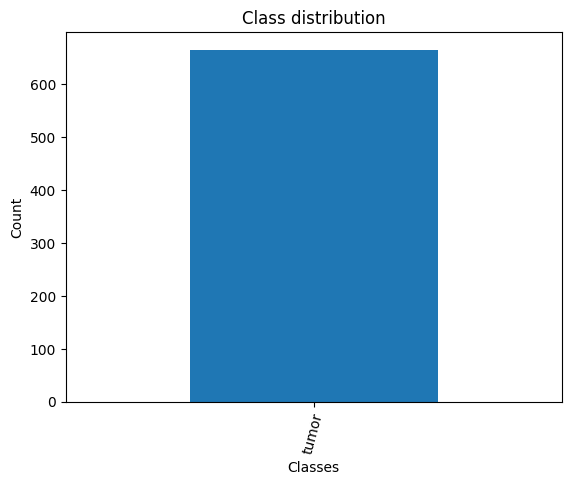

In [ ]:
class_counts = shapes_df['label'].value_counts()

class_counts.plot(kind='bar')
plt.title('Class distribution')
plt.ylabel('Count')
plt.xlabel('Classes')
plt.xticks(range(len(class_counts.index)), class_names, rotation=75)
plt.show()

#### Add a background class

In [ ]:
class_names = ['background']+class_names

pd.DataFrame(class_names)

,0
0,background
1,tumor


### Visualizing Image Annotations

#### Color & font

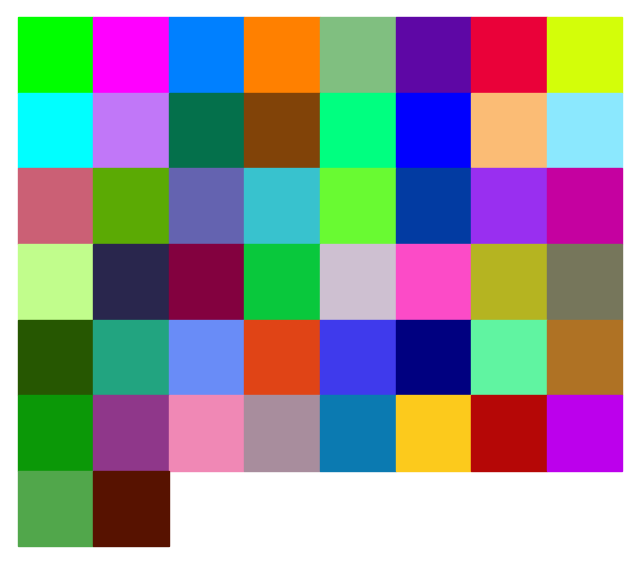

In [ ]:
colors = distinctipy.get_colors(50)
distinctipy.color_swatch(colors)


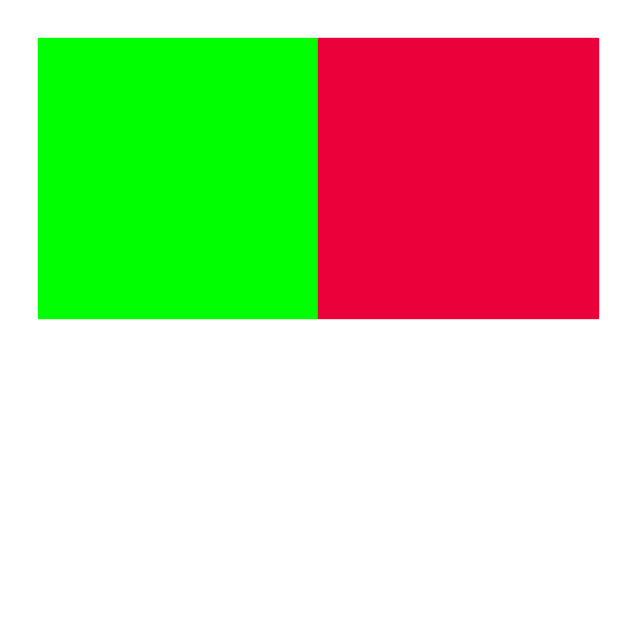

In [ ]:
selected_color = colors[0],colors[6]
int_colors = [tuple(int(c*255) for c in color) for color in selected_color]

distinctipy.color_swatch(selected_color)

In [ ]:
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

  0%|          | 0.00/130k [00:00<?, ?iB/s]

In [ ]:
draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2, font=font_file, font_size=20)

### Selecting a Sample Image

#### Load the sample image

Image Dims: (283, 334)


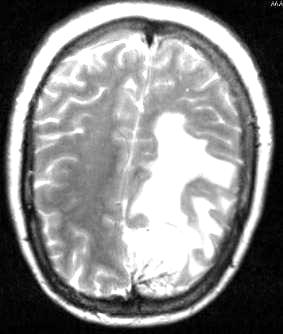

In [ ]:
file_id = list(img_dict.keys())[42]

sample_img = Image.open(img_dict[file_id]).convert('RGB')

print(f"Image Dims: {sample_img.size}")

sample_img

In [ ]:
annotation_df.loc[file_id].to_frame()

,y150
version,4.5.6
flags,{}
shapes,"[{'label': 'tumor', 'points': [[232, 186], [235, 167], [169, 111], [157, 119], [155, 140], [157, 155], [150, 163], [146, 177], [141, 187], [131, 203], [128, 215], [128, 237], [128, 253], [135, 271], [140, 283], [165, 277], [179, 272], [194, 272], [201, 263], [211, 257], [213, 237], [224, 232], [184, 190], [198, 177]], 'group_id': None, 'shape_type': 'polygon', 'flags': {}}]"
imagePath,y150.jpg
imageData,None
imageHeight,334
imageWidth,283


In [ ]:
def create_polygon_mask(image_size, vertices):
    mask_img = Image.new('L', image_size, 0)
    ImageDraw.Draw(mask_img, 'L').polygon(vertices, fill=(255))
    return mask_img

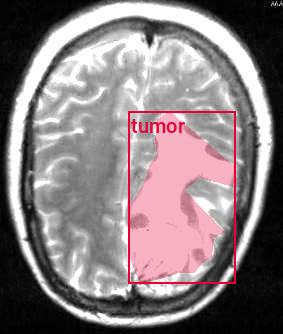

In [ ]:
labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]
shape_points = [shape['points'] for shape in annotation_df.loc[file_id]['shapes']]
xy_coords = [[tuple(p) for p in points] for points in shape_points]
mask_imgs = [create_polygon_mask(sample_img.size, xy) for xy in xy_coords]
masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])
bboxes = torchvision.ops.masks_to_boxes(masks)

annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sample_img),
    masks=masks,
    alpha=0.3,
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

annotated_tensor = draw_bboxes(
    image=annotated_tensor,
    boxes=bboxes,
    labels=labels,
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

tensor_to_pil(annotated_tensor)

## Loading the Mask R-CNN Model

In [ ]:
model = maskrcnn_resnet50_fpn_v2(weights='DEFAULT')

in_features_box = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=len(class_names))
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=dim_reduced, num_classes=len(class_names))

model.to(device=device, dtype=dtype);
model.device = device
model.name = 'maskrcnn_resnet50_fpn_v2'

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:01<00:00, 129MB/s]


### Summarizing the Model

In [ ]:
test_inp = torch.randn(1, 3, 256, 256).to(device)
summary_df = markdown_to_pandas(f"{get_module_summary(model.eval(), [test_inp])}")
summary_df = summary_df[summary_df.index == 0]
summary_df.drop(['In size', 'Out size', 'Contains Uninitialized Parameters?'], axis=1)

/usr/local/lib/python3.10/dist-packages/torchtnt/utils/module_summary.py:271: UserWarning: Backward FLOPs are only computed if module foward returns a tensor.
  warnings.warn(


,Type,# Parameters,# Trainable Parameters,Size (bytes),Forward FLOPs
0,MaskRCNN,45.9 M,45.7 M,183 M,331 G


## Preparing the Data

### Training-Validation Split

In [ ]:
img_keys = list(img_dict.keys())
random.shuffle(img_keys)

train_pct = 0.8
val_pct = 0.2

train_split = int(len(img_keys)*train_pct)
val_split = int(len(img_keys)*(train_pct+val_pct))

train_keys = img_keys[:train_split]
val_keys = img_keys[train_split:]

pd.Series({
    "Training Samples:": len(train_keys),
    "Validation Samples:": len(val_keys)
}).to_frame().style.hide(axis='columns')

Training Samples:,509
Validation Samples:,128


### Data Augmentation

In [ ]:
train_sz = 512

#### Initialize the transforms

In [ ]:
iou_crop = CustomRandomIoUCrop(min_scale=0.3,
                               max_scale=0.6,
                               min_aspect_ratio=0.5,
                               max_aspect_ratio=2.0,
                               sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                               trials=400,
                               jitter_factor=0.25)
resize_max = ResizeMax(max_sz=train_sz)
pad_square = PadSquare(shift=True, fill=0)

#### Test the transforms

In [ ]:
labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]
shape_points = [shape['points'] for shape in annotation_df.loc[file_id]['shapes']]
xy_coords = [[tuple(p) for p in points] for points in shape_points]
mask_imgs = [create_polygon_mask(sample_img.size, xy) for xy in xy_coords]
masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])
bboxes = BoundingBoxes(data=torchvision.ops.masks_to_boxes(masks), format='xyxy', canvas_size=sample_img.size[::-1])
sample_colors = [int_colors[i] for i in [class_names.index(label) for label in labels]]

targets = {
    'masks': Mask(masks),
    'boxes': bboxes,
    'labels': torch.Tensor([class_names.index(label) for label in labels])
}

cropped_img, targets = iou_crop(sample_img, targets)
resized_img, targets = resize_max(cropped_img, targets)
padded_img, targets = pad_square(resized_img, targets)

resize = transforms.Resize([train_sz] * 2, antialias=True)
resized_padded_img, targets = resize(padded_img, targets)
sanitized_img, targets = transforms.SanitizeBoundingBoxes()(resized_padded_img, targets)

annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sanitized_img),
    masks=targets['masks'],
    alpha=0.3,
    colors=sample_colors
)

annotated_tensor = draw_bboxes(
    image=annotated_tensor,
    boxes=targets['boxes'],
    labels=[class_names[int(label.item())] for label in targets['labels']],
    colors=sample_colors
)

display(tensor_to_pil(annotated_tensor))

pd.Series({
    "Source Image:": sample_img.size,
    "Cropped Image:": cropped_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')

### Custom Dataset Class

In [ ]:
class BrainTumorDataset(Dataset):
    def __init__(self, img_keys, annotation_df, img_dict, class_to_idx, transforms=None):
        super(Dataset, self).__init__()

        self._img_keys = img_keys
        self._annotation_df = annotation_df
        self._img_dict = img_dict
        self._class_to_idx = class_to_idx
        self._transforms = transforms

    def __len__(self):
        return len(self._img_keys)

    def __getitem__(self, index):
        img_key = self._img_keys[index]
        annotation = self._annotation_df.loc[img_key]
        image, target = self._load_image_and_target(annotation)
        if self._transforms:
            image, target = self._transforms(image, target)
        return image, target

    def _load_image_and_target(self, annotation):
        filepath = self._img_dict[annotation.name]
        image = Image.open(filepath).convert('RGB')
        labels = [shape['label'] for shape in annotation['shapes']]
        labels = torch.Tensor([self._class_to_idx[label] for label in labels])
        labels = labels.to(dtype=torch.int64)

        shape_points = [shape['points'] for shape in annotation['shapes']]
        xy_coords = [[tuple(p) for p in points] for points in shape_points]
        mask_imgs = [create_polygon_mask(image.size, xy) for xy in xy_coords]
        masks = Mask(torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs]))
        bboxes = BoundingBoxes(data=torchvision.ops.masks_to_boxes(masks), format='xyxy', canvas_size=image.size[::-1])

        return image, {'masks': masks,'boxes': bboxes, 'labels': labels}

### Image Transforms

In [ ]:
data_aug_tfms = transforms.Compose(
    transforms=[
        iou_crop,
        transforms.ColorJitter(
                brightness = (0.875, 1.125),
                contrast = (0.5, 1.5),
                saturation = (0.5, 1.5),
                hue = (-0.05, 0.05),
        ),
        transforms.RandomGrayscale(),
        transforms.RandomEqualize(),
        transforms.RandomPosterize(bits=3, p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
    ],
)

resize_pad_tfm = transforms.Compose([
    resize_max,
    pad_square,
    transforms.Resize([train_sz] * 2, antialias=True)
])

final_tfms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.SanitizeBoundingBoxes(),
])

train_tfms = transforms.Compose([
    data_aug_tfms,
    resize_pad_tfm,
    final_tfms
])
valid_tfms = transforms.Compose([resize_pad_tfm, final_tfms])

### Initialize Datasets

In [ ]:
class_to_idx = {c: i for i, c in enumerate(class_names)}

train_dataset = BrainTumorDataset(train_keys, annotation_df, img_dict, class_to_idx, train_tfms)
valid_dataset = BrainTumorDataset(val_keys, annotation_df, img_dict, class_to_idx, valid_tfms)

pd.Series({
    'Training dataset size:': len(train_dataset),
    'Validation dataset size:': len(valid_dataset)}
).to_frame().style.hide(axis='columns')

Training dataset size:,509
Validation dataset size:,128


### Inspect Samples

#### Inspect training set sample

In [ ]:
dataset_sample = train_dataset[0]
sample_colors = [int_colors[int(i.item())] for i in dataset_sample[1]['labels']]
annotated_tensor = draw_segmentation_masks(
    image=(dataset_sample[0]*255).to(dtype=torch.uint8),
    masks=dataset_sample[1]['masks'],
    alpha=0.3,
    colors=sample_colors
)
annotated_tensor = draw_bboxes(
    image=annotated_tensor,
    boxes=dataset_sample[1]['boxes'],
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']],
    colors=sample_colors
)

tensor_to_pil(annotated_tensor)

#### Inspect validation set sample

In [ ]:
dataset_sample = valid_dataset[0]
sample_colors = [int_colors[int(i.item())] for i in dataset_sample[1]['labels']]
annotated_tensor = draw_segmentation_masks(
    image=(dataset_sample[0]*255).to(dtype=torch.uint8),
    masks=dataset_sample[1]['masks'],
    alpha=0.3,
    colors=sample_colors
)
annotated_tensor = draw_bboxes(
    image=annotated_tensor,
    boxes=dataset_sample[1]['boxes'],
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']],
    colors=sample_colors
)

tensor_to_pil(annotated_tensor)

### Initialize DataLoaders

In [ ]:
bs = 4
num_workers = multiprocessing.cpu_count()//2
data_loader_params = {
    'batch_size': bs,
    'num_workers': num_workers,
    'persistent_workers': True,
    'pin_memory': 'cuda' in device,
    'pin_memory_device': device if 'cuda' in device else '',
    'collate_fn': lambda batch: tuple(zip(*batch)),
}
train_dataloader = DataLoader(train_dataset, **data_loader_params, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, **data_loader_params)

pd.Series({
    'Number of batches in train DataLoader:': len(train_dataloader),
    'Number of batches in validation DataLoader:': len(valid_dataloader)}
).to_frame().style.hide(axis='columns')

Number of batches in train DataLoader:,128
Number of batches in validation DataLoader:,32


## Fine-tuning the Model

In [ ]:
def run_epoch(model, dataloader, optimizer, lr_scheduler, device, scaler, epoch_id, is_training):
    model.train()

    epoch_loss = 0
    progress_bar = tqdm(total=len(dataloader), desc="Train" if is_training else "Eval")

    for batch_id, (inputs, targets) in enumerate(dataloader):
        inputs = torch.stack(inputs).to(device)

        with autocast(torch.device(device).type):
            if is_training:
                losses = model(inputs.to(device), move_data_to_device(targets, device))
            else:
                with torch.no_grad():
                    losses = model(inputs.to(device), move_data_to_device(targets, device))

            loss = sum([loss for loss in losses.values()])
            extracted_losses = {key: value.item() for key, value in losses.items()}
            extracted_losses['net_loss'] = loss.item()
            if is_training:
                wandb.log({'epoch':epoch_id,'training_losses':extracted_losses})
            else:
                wandb.log({'epoch':epoch_id,'validation_losses':extracted_losses})
        if is_training:
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                old_scaler = scaler.get_scale()
                scaler.update()
                new_scaler = scaler.get_scale()
                if new_scaler >= old_scaler:
                    lr_scheduler.step()
            else:
                loss.backward()
                optimizer.step()
                lr_scheduler.step()

            optimizer.zero_grad()

        loss_item = loss.item()
        epoch_loss += loss_item

        progress_bar_dict = dict(loss=loss_item, avg_loss=epoch_loss/(batch_id+1))
        if is_training:
            progress_bar_dict.update(lr=lr_scheduler.get_last_lr()[0])
        progress_bar.set_postfix(progress_bar_dict)
        progress_bar.update()

        if is_training:
            stop_training_message = f"Loss is NaN or infinite at epoch {epoch_id}, batch {batch_id}. Stopping training."
            assert not math.isnan(loss_item) and math.isfinite(loss_item), stop_training_message

    progress_bar.close()

    return epoch_loss / (batch_id + 1)

def train_loop(model,
               train_dataloader,
               valid_dataloader,
               optimizer,
               lr_scheduler,
               device,
               epochs,
               checkpoint_path,
               use_scaler=False):
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' and use_scaler else None
    best_loss = float('inf')
    wandb.watch(model, log="all", log_freq=10)
    for epoch in tqdm(range(epochs), desc="Epochs"):
        train_loss = run_epoch(model, train_dataloader, optimizer, lr_scheduler, device, scaler, epoch, is_training=True)
        with torch.no_grad():
            valid_loss = run_epoch(model, valid_dataloader, None, None, device, scaler, epoch, is_training=False)

        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

            training_metadata = {
                'epoch': epoch,
                'train_loss': train_loss,
                'valid_loss': valid_loss,
                'learning_rate': lr_scheduler.get_last_lr()[0],
                'model_architecture': model.name
            }
            with open(Path(checkpoint_path.parent/'training_metadata.json'), 'w') as f:
                json.dump(training_metadata, f)

    # onnx_file_path = f"{checkpoint_dir}/{checkpoint_path.stem}.onnx"

    # torch.onnx.export(model.cpu(),
    #                   input_tensor.cpu(),
    #                   onnx_file_path,
    #                   export_params=True,
    #                   do_constant_folding=False,
    #                   input_names = ['input'],
    #                   output_names = ['boxes', 'labels', 'scores', 'masks'],
    #                   dynamic_axes={'input': {2 : 'height', 3 : 'width'}}
    #                 )
    # wandb.save(onnx_file_path)
    # If the device is a GPU, empty the cache
    if device.type != 'cpu':
        getattr(torch, device.type).empty_cache()

### Set the Model Checkpoint Path

In [ ]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
checkpoint_dir = Path(project_dir/f"{timestamp}")
checkpoint_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = checkpoint_dir/f"{model.name}.pth"

print(checkpoint_path)

### Save the Color Map

In [ ]:
color_map = {'items': [{'label': label, 'color': color} for label, color in zip(class_names, colors)]}
with open(f"{checkpoint_dir}/{dataset_path.name}-colormap.json", "w") as file:
    json.dump(color_map, file)

print(f"{checkpoint_dir}/{dataset_path.name}-colormap.json")

BrainTumor_Segmentation_MaskRCNN/2024-03-18_23-53-24/Br35H-Mask-RCNN-colormap.json


### Configure the Training Parameters

In [ ]:
lr = 4e-4
epochs = 50
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                   max_lr=lr,
                                                   total_steps=epochs*len(train_dataloader))

### Track metadata and hyperparameters with wandb

In [ ]:
config = dict(
    epochs=epochs,
    learning_rate = lr,
    learning_rate_scheduler='OneCycleLR',
    batch_size=bs,
    optimizer = 'AdamW',
    classification_loss = 'Cross Entropy',
    bbox_loss = 'Smooth L1 Regression',
    mask_loss = 'Binary Cross Entropy',
    classes=class_names,
    number_of_classes = len(class_names),
    dataset=f"Br35H - {dataset_name}({gh_repo})",
    train_data = len(train_dataset),
    validation_data = len(valid_dataset),
    data_augmentations = ['RandomIOUCrop','RandomGrayscale','RandomEqualize','RandomPosterize','RandomHorizontalFlip'],
    architecture="MaskRCNN",
    device = device,
    mixed_point_precision=True,
    automatic_mixed_precision=True)

In [ ]:
wandb.init(
    project=project_name,
    config=config
)

### Train the Model

In [ ]:
train_loop(model=model,
           train_dataloader=train_dataloader,
           valid_dataloader=valid_dataloader,
           optimizer=optimizer,
           lr_scheduler=lr_scheduler,
           device=torch.device(device),
           epochs=epochs,
           checkpoint_path=checkpoint_path,
           use_scaler=True)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/128 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

## Making Predictions with the Model

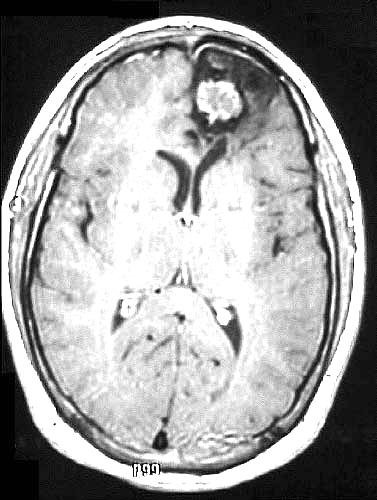

Source Image Size:,"(377, 500)"
Input Dims:,"(509, 675)"
Min Image Scale:,0.740668
Input Image Size:,"(509, 675)"


In [ ]:
file_id = random.choice(val_keys)
test_file = img_dict[file_id]

test_img = Image.open(test_file).convert('RGB')

input_img = resize_img(test_img, target_sz=train_sz, divisor=1)

min_img_scale = min(test_img.size) / min(input_img.size)

display(test_img)
pd.Series({
    "Source Image Size:": test_img.size,
    "Input Dims:": input_img.size,
    "Min Image Scale:": min_img_scale,
    "Input Image Size:": input_img.size
}).to_frame().style.hide(axis='columns')

In [ ]:
target_shape_points = [shape['points'] for shape in annotation_df.loc[file_id]['shapes']]
target_xy_coords = [[tuple(p) for p in points] for points in target_shape_points]
target_mask_imgs = [create_polygon_mask(test_img.size, xy) for xy in target_xy_coords]
target_masks = Mask(torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in target_mask_imgs]))

target_labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]
target_bboxes = BoundingBoxes(data=torchvision.ops.masks_to_boxes(target_masks), format='xyxy', canvas_size=test_img.size[::-1])

In [ ]:
model.eval();

model.to(device)
input_tensor = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])(input_img)[None].to(device)

with torch.no_grad():
    model_output = model(input_tensor)

In [ ]:
threshold = 0.5

model_output = move_data_to_device(model_output, 'cpu')
scores_mask = model_output[0]['scores'] > threshold
pred_bboxes = BoundingBoxes(model_output[0]['boxes'][scores_mask]*min_img_scale, format='xyxy', canvas_size=input_img.size[::-1])
pred_labels = [class_names[int(label)] for label in model_output[0]['labels'][scores_mask]]
pred_scores = model_output[0]['scores']
# pred_scores = model_output[0]['scores'][scores_mask]
pred_masks = F.interpolate(model_output[0]['masks'][scores_mask], size=test_img.size[::-1])
pred_masks = torch.concat([Mask(torch.where(mask >= threshold, 1, 0), dtype=torch.bool) for mask in pred_masks])

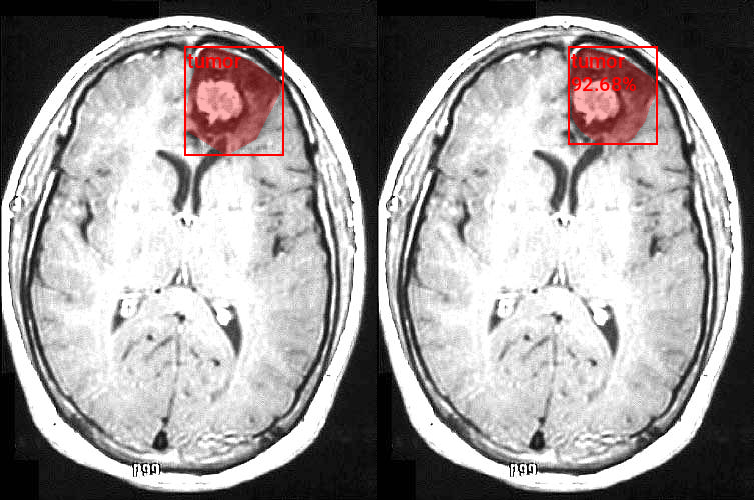

Target BBoxes:,['tumor:[184. 46. 283. 155.]']
Predicted BBoxes:,['tumor:[191.42 46.308 280.074 144.923]']
Confidence Scores:,['tumor: 92.68%']


In [ ]:
target_colors=[int_colors[i] for i in [class_names.index(label) for label in target_labels]]
pred_colors=[int_colors[i] for i in [class_names.index(label) for label in pred_labels]]

img_tensor = transforms.PILToTensor()(test_img)

annotated_tensor = draw_segmentation_masks(image=img_tensor, masks=target_masks, alpha=0.3, colors=target_colors)
annotated_tensor = draw_bboxes(image=annotated_tensor, boxes=target_bboxes, labels=target_labels, colors=target_colors)
annotated_test_img = tensor_to_pil(annotated_tensor)

annotated_tensor = draw_segmentation_masks(image=img_tensor, masks=pred_masks, alpha=0.3, colors=pred_colors)
annotated_tensor = draw_bboxes(
    image=annotated_tensor,
    boxes=pred_bboxes,
    labels=[f"{label}\n{prob*100:.2f}%" for label, prob in zip(pred_labels, pred_scores)],
    colors=pred_colors
)

display(stack_imgs([annotated_test_img, tensor_to_pil(annotated_tensor)]))

pd.Series({
    "Target BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(target_labels, np.round(target_bboxes.numpy(), decimals=3))],
    "Predicted BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(pred_labels, pred_bboxes.round(decimals=3).numpy())],
    "Confidence Scores:": [f"{label}: {prob*100:.2f}%" for label, prob in zip(pred_labels, pred_scores)]
}).to_frame().style.hide(axis='columns')

### Zip the trained model

In [ ]:
import shutil

def zip_directory(folder_path, output_filename):
    shutil.make_archive(output_filename, 'zip', folder_path)
    print(f"Created zip archive: {output_filename}.zip")



In [ ]:
# Example usage
folder_path = '/content/BrainTumor_Segmentation_MaskRCNN/2024-03-18_19-14-18'  # Replace with the path to your folder
output_filename = '/content/Brain_Tumor_Segmentation_MaskRCNN_2024-03-18_19-14-18'  # Replace with your desired output path and filename without the .zip extension
zip_directory(folder_path, output_filename)

Created zip archive: content/Brain_Tumor_Segmentation_MaskRCNN_2024-03-18_19-14-18.zip


### Load the trained model

In [ ]:
!unzip Brain_Tumor_Segmentation_MaskRCNN_2024-03-18_19-14-18.zip -d ./Brain_Tumor_Segmentation_MaskRCNN_2024-03-18_19-14-18

Archive:  Brain_Tumor_Segmentation_MaskRCNN_2024-03-18_19-14-18.zip
  inflating: ./Brain_Tumor_Segmentation_MaskRCNN_2024-03-18_19-14-18/Br35H-Mask-RCNN-colormap.json  
  inflating: ./Brain_Tumor_Segmentation_MaskRCNN_2024-03-18_19-14-18/training_metadata.json  
  inflating: ./Brain_Tumor_Segmentation_MaskRCNN_2024-03-18_19-14-18/maskrcnn_resnet50_fpn_v2.pth  


In [ ]:
checkpoint_path = '/content/Brain_Tumor_Segmentation_MaskRCNN_2024-03-18_19-14-18/maskrcnn_resnet50_fpn_v2.pth'

model_checkpoint = torch.load(checkpoint_path, map_location='cpu')
model = maskrcnn_resnet50_fpn_v2(weights='DEFAULT')

in_features_box = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

model.roi_heads.box_predictor = FastRCNNPredictor(in_features_box, len(class_names))

model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=256, num_classes=len(class_names))

model.load_state_dict(model_checkpoint)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:01<00:00, 148MB/s]


<All keys matched successfully>

### Test it out

In [ ]:
test_file = '/content/trash/no/no1052.jpg'

test_img = Image.open(test_file).convert('RGB')

input_img = resize_img(test_img, target_sz=train_sz, divisor=1)

min_img_scale = min(test_img.size) / min(input_img.size)

display(test_img)
pd.Series({
    "Source Image Size:": test_img.size,
    "Input Dims:": input_img.size,
    "Min Image Scale:": min_img_scale,
    "Input Image Size:": input_img.size
}).to_frame().style.hide(axis='columns')

In [ ]:
# target_shape_points = [shape['points'] for shape in annotation_df.loc[file_id]['shapes']]
# target_xy_coords = [[tuple(p) for p in points] for points in target_shape_points]
# target_mask_imgs = [create_polygon_mask(test_img.size, xy) for xy in target_xy_coords]
# target_masks = Mask(torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in target_mask_imgs]))

# target_labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]
# target_bboxes = BoundingBoxes(data=torchvision.ops.masks_to_boxes(target_masks), format='xyxy', canvas_size=test_img.size[::-1])

#### Pass the input data to the model

In [ ]:
model.eval();

model.to(device)
input_tensor = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])(input_img)[None].to(device)

with torch.no_grad():
    model_output = model(input_tensor)

In [ ]:
model_output[0]['scores'][model_output[0]['scores'] > threshold].shape

torch.Size([1])

#### Filter the model output

In [ ]:
threshold = 0.5
if model_output[0]['scores'].shape[0]:
    model_output = move_data_to_device(model_output, 'cpu')
    scores_mask = model_output[0]['scores'] > threshold
    if model_output[0]['scores'][model_output[0]['scores'] > threshold].shape[0]:
        pred_bboxes = BoundingBoxes(model_output[0]['boxes'][scores_mask]*min_img_scale, format='xyxy', canvas_size=input_img.size[::-1])
        pred_labels = [class_names[int(label)] for label in model_output[0]['labels'][scores_mask]]
        pred_scores = model_output[0]['scores']
        # pred_scores = model_output[0]['scores'][scores_mask]
        pred_masks = F.interpolate(model_output[0]['masks'][scores_mask], size=test_img.size[::-1])
        pred_masks = torch.concat([Mask(torch.where(mask >= threshold, 1, 0), dtype=torch.bool) for mask in pred_masks])

#### Annotate the image using the model predictions

In [ ]:
# target_colors=[int_colors[i] for i in [class_names.index(label) for label in target_labels]]
pred_colors=[int_colors[i] for i in [class_names.index(label) for label in pred_labels]]

img_tensor = transforms.PILToTensor()(test_img)

# annotated_tensor = draw_segmentation_masks(image=img_tensor, masks=target_masks, alpha=0.3, colors=target_colors)
# annotated_tensor = draw_bboxes(image=annotated_tensor, boxes=target_bboxes, labels=target_labels, colors=target_colors)
# annotated_test_img = tensor_to_pil(annotated_tensor)

annotated_tensor = draw_segmentation_masks(image=img_tensor, masks=pred_masks, alpha=0.3, colors=pred_colors)
annotated_tensor = draw_bboxes(
    image=annotated_tensor,
    boxes=pred_bboxes,
    labels=[f"{label}\n{prob*100:.2f}%" for label, prob in zip(pred_labels, pred_scores)],
    colors=pred_colors
)

display(stack_imgs([test_img, tensor_to_pil(annotated_tensor)]))

# pd.Series({
#     "Target BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(target_labels, np.round(target_bboxes.numpy(), decimals=3))],
#     "Predicted BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(pred_labels, pred_bboxes.round(decimals=3).numpy())],
#     "Confidence Scores:": [f"{label}: {prob*100:.2f}%" for label, prob in zip(pred_labels, pred_scores)]
# }).to_frame().style.hide(axis='columns')
pd.Series({
    "Predicted BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(pred_labels, pred_bboxes.round(decimals=3).numpy())],
    "Confidence Scores:": [f"{label}: {prob*100:.2f}%" for label, prob in zip(pred_labels, pred_scores)]
}).to_frame().style.hide(axis='columns')

### Optimal Threshold

In [ ]:
# model.to(device)
model.eval()
def calculate_metrics(true_mask, pred_mask):
    true_mask_flat = true_mask.flatten().astype(bool)
    pred_mask_flat = pred_mask.flatten().astype(bool)

    pixel_accuracy = accuracy_score(true_mask_flat, pred_mask_flat)
    dice = f1_score(true_mask_flat, pred_mask_flat,zero_division=0)
    precision = precision_score(true_mask_flat, pred_mask_flat, zero_division=0)
    recall = recall_score(true_mask_flat, pred_mask_flat, zero_division=0)
    iou = jaccard_score(true_mask_flat, pred_mask_flat, zero_division=0)

    return pixel_accuracy, dice, precision, recall, iou

thresholds = np.linspace(0, 1, 10)
pixel_accuracy_list, dice_list, precision_list, recall_list, iou_list = [], [], [], [], []

for threshold in thresholds:
    pixel_accuracies, dices, precisions, recalls, ious = [], [], [], [], []

    for images, targets in tqdm(valid_dataloader, desc="Evaluating Model"):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            outputs = model(images)

        for i, output in enumerate(outputs):
            if 'masks' in output and output['masks'].numel() > 0:
                pred_mask = output['masks'][0, 0] > threshold
            else:
                true_mask_shape = targets[i]['masks'].shape
                pred_mask = torch.zeros(true_mask_shape).to(device) > threshold

            true_mask = targets[i]['masks'][0] > threshold

            pixel_accuracy, dice, precision, recall, iou = calculate_metrics(true_mask.cpu().numpy(), pred_mask.cpu().numpy())

            pixel_accuracies.append(pixel_accuracy)
            dices.append(dice)
            precisions.append(precision)
            recalls.append(recall)
            ious.append(iou)

    pixel_accuracy_list.append(np.mean(pixel_accuracies))
    dice_list.append(np.mean(dices))
    precision_list.append(np.mean(precisions))
    recall_list.append(np.mean(recalls))
    iou_list.append(np.mean(ious))


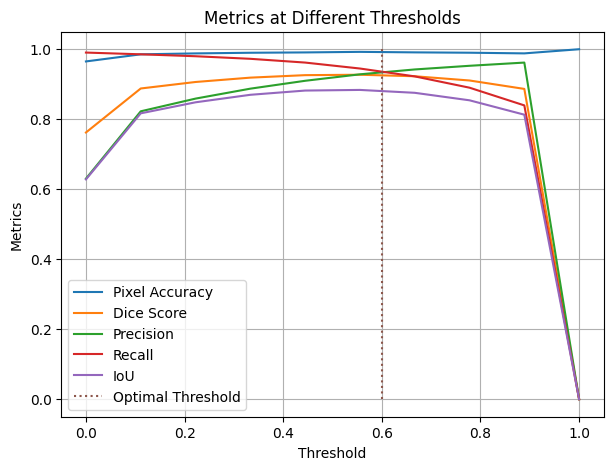

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(thresholds, pixel_accuracy_list, label='Pixel Accuracy')
plt.plot(thresholds, dice_list, label='Dice Score')
plt.plot(thresholds, precision_list, label='Precision')
plt.plot(thresholds, recall_list, label='Recall')
plt.plot(thresholds, iou_list, label='IoU')
plt.plot([0.6]*len(thresholds), np.linspace(0,1,10), linestyle=':',label='Optimal Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.title('Metrics at Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()

### Evaluate

In [ ]:
# @title
model.eval()

In [ ]:
# @title
class SegmentationMetrics(object):
    r"""Calculate common metrics in semantic segmentation to evalueate model preformance.

    Supported metrics: Pixel accuracy, Dice Coeff, precision score and recall score.

    Pixel accuracy measures how many pixels in a image are predicted correctly.

    Dice Coeff is a measure function to measure similarity over 2 sets, which is usually used to
    calculate the similarity of two samples. Dice equals to f1 score in semantic segmentation tasks.

    It should be noted that Dice Coeff and Intersection over Union are highly related, so you need
    NOT calculate these metrics both, the other can be calcultaed directly when knowing one of them.

    Precision describes the purity of our positive detections relative to the ground truth. Of all
    the objects that we predicted in a given image, precision score describes how many of those objects
    actually had a matching ground truth annotation.

    Recall describes the completeness of our positive predictions relative to the ground truth. Of
    all the objected annotated in our ground truth, recall score describes how many true positive instances
    we have captured in semantic segmentation.

    Args:
        eps: float, a value added to the denominator for numerical stability.
            Default: 1e-5

        average: bool. Default: ``True``
            When set to ``True``, average Dice Coeff, precision and recall are
            returned. Otherwise Dice Coeff, precision and recall of each class
            will be returned as a numpy array.

        ignore_background: bool. Default: ``True``
            When set to ``True``, the class will not calculate related metrics on
            background pixels. When the segmentation of background pixels is not
            important, set this value to ``True``.

        activation: [None, 'none', 'softmax' (default), 'sigmoid', '0-1']
            This parameter determines what kind of activation function that will be
            applied on model output.

    Input:
        y_true: :math:`(N, H, W)`, torch tensor, where we use int value between (0, num_class - 1)
        to denote every class, where ``0`` denotes background class.
        y_pred: :math:`(N, C, H, W)`, torch tensor.

    Examples::
        >>> metric_calculator = SegmentationMetrics(average=True, ignore_background=True)
        >>> pixel_accuracy, dice, precision, recall = metric_calculator(y_true, y_pred)
    """
    def __init__(self, eps=1e-5, average=True, ignore_background=True, activation='none'):
        self.eps = eps
        self.average = average
        self.ignore = ignore_background
        self.activation = activation

    @staticmethod
    def _one_hot(gt, pred, class_num):
        # transform sparse mask into one-hot mask
        # shape: (B, H, W) -> (B, C, H, W)
        input_shape = tuple(gt.shape)  # (N, H, W, ...)
        new_shape = (input_shape[0], class_num) + input_shape[1:]
        one_hot = torch.zeros(new_shape).to(pred.device, dtype=torch.float)
        target = one_hot.scatter_(1, gt.unsqueeze(1).long().data, 1.0)
        return target

    @staticmethod
    def _get_class_data(gt_onehot, pred, class_num):
        # perform calculation on a batch
        # for precise result in a single image, plz set batch size to 1
        matrix = np.zeros((3, class_num))

        # calculate tp, fp, fn per class
        for i in range(class_num):
            # pred shape: (N, H, W)
            class_pred = pred[:, i, :, :]
            # gt shape: (N, H, W), binary array where 0 denotes negative and 1 denotes positive
            class_gt = gt_onehot[:, i, :, :]

            pred_flat = class_pred.contiguous().view(-1, )  # shape: (N * H * W, )
            gt_flat = class_gt.contiguous().view(-1, )  # shape: (N * H * W, )

            tp = torch.sum(gt_flat * pred_flat)
            fp = torch.sum(pred_flat) - tp
            fn = torch.sum(gt_flat) - tp

            matrix[:, i] = tp.item(), fp.item(), fn.item()

        return matrix

    def _calculate_multi_metrics(self, gt, pred, class_num):
        # calculate metrics in multi-class segmentation
        matrix = self._get_class_data(gt, pred, class_num)
        if self.ignore:
            matrix = matrix[:, 1:]

        # tp = np.sum(matrix[0, :])
        # fp = np.sum(matrix[1, :])
        # fn = np.sum(matrix[2, :])

        pixel_acc = (np.sum(matrix[0, :]) + self.eps) / (np.sum(matrix[0, :]) + np.sum(matrix[1, :]))
        dice = (2 * matrix[0] + self.eps) / (2 * matrix[0] + matrix[1] + matrix[2] + self.eps)
        precision = (matrix[0] + self.eps) / (matrix[0] + matrix[1] + self.eps)
        recall = (matrix[0] + self.eps) / (matrix[0] + matrix[2] + self.eps)

        if self.average:
            dice = np.average(dice)
            precision = np.average(precision)
            recall = np.average(recall)

        return pixel_acc, dice, precision, recall

    def __call__(self, y_true, y_pred):
        class_num = y_pred.size(1)

        if self.activation in [None, 'none']:
            activation_fn = lambda x: x
            activated_pred = activation_fn(y_pred)
        elif self.activation == "sigmoid":
            activation_fn = nn.Sigmoid()
            activated_pred = activation_fn(y_pred)
        elif self.activation == "softmax":
            activation_fn = nn.Softmax(dim=1)
            activated_pred = activation_fn(y_pred)
        elif self.activation == "0-1":
            pred_argmax = torch.argmax(y_pred, dim=1)
            activated_pred = self._one_hot(pred_argmax, y_pred, class_num)
        else:
            raise NotImplementedError("Not a supported activation!")

        gt_onehot = self._one_hot(y_true, y_pred, class_num)
        pixel_acc, dice, precision, recall = self._calculate_multi_metrics(gt_onehot, activated_pred, class_num)
        return pixel_acc, dice, precision, recall


class BinaryMetrics():
    r"""Calculate common metrics in binary cases.
    In binary cases it should be noted that y_pred shape shall be like (N, 1, H, W), or an assertion
    error will be raised.
    Also this calculator provides the function to calculate specificity, also known as true negative
    rate, as specificity/TPR is meaningless in multiclass cases.
    """
    def __init__(self, eps=1e-5, activation='0-1'):
        self.eps = eps
        self.activation = activation

    def _calculate_overlap_metrics(self, gt, pred):
        output = pred.view(-1, )
        target = gt.view(-1, ).float()

        tp = torch.sum(output * target)  # TP
        fp = torch.sum(output * (1 - target))  # FP
        fn = torch.sum((1 - output) * target)  # FN
        tn = torch.sum((1 - output) * (1 - target))  # TN

        pixel_acc = (tp + tn + self.eps) / (tp + tn + fp + fn + self.eps)
        dice = (2 * tp + self.eps) / (2 * tp + fp + fn + self.eps)
        precision = (tp + self.eps) / (tp + fp + self.eps)
        recall = (tp + self.eps) / (tp + fn + self.eps)
        specificity = (tn + self.eps) / (tn + fp + self.eps)

        return pixel_acc, dice, precision, specificity, recall

    def __call__(self, y_true, y_pred):
        # y_true: (N, H, W)
        # y_pred: (N, 1, H, W)
        if self.activation in [None, 'none']:
            activation_fn = lambda x: x
            activated_pred = activation_fn(y_pred)
        elif self.activation == "sigmoid":
            activation_fn = nn.Sigmoid()
            activated_pred = activation_fn(y_pred)
        elif self.activation == "0-1":
            sigmoid_pred = nn.Sigmoid()(y_pred)
            activated_pred = (sigmoid_pred > 0.5).float().to(y_pred.device)
        else:
            raise NotImplementedError("Not a supported activation!")

        assert activated_pred.shape[1] == 1, 'Predictions must contain only one channel' \
                                             ' when performing binary segmentation'
        pixel_acc, dice, precision, specificity, recall = self._calculate_overlap_metrics(y_true.to(y_pred.device,
                                                                                                    dtype=torch.float),
                                                                                          activated_pred)
        return [pixel_acc, dice, precision, specificity, recall]

In [ ]:
# @title
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

metrics_results = {"pixel_accuracy": [], "dice": [], "precision": [], "recall": [], "iou": []}
metrics_calculator = SegmentationMetrics(average=True, ignore_background=True)

for images, targets in tqdm(valid_dataloader, desc="Evaluating Model"):
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    with torch.no_grad():
        outputs = model(images)

    for i, output in enumerate(outputs):
        # Assuming the first mask is the relevant one; adjust based on your data
        pred_mask = output['masks'][0, 0] > 0.5  # Threshold to get a binary mask

        # Assuming the corresponding true mask is in the same position
        true_mask = targets[i]['masks'][0]
        true_mask = true_mask > 0.5  # Ensure this is a boolean mask for consistency

        # Calculate metrics
        pixel_accuracy, dice, precision, recall, iou = metrics_calculator(true_masks, pred_masks)

        # Store results
        metrics_results["pixel_accuracy"].append(pixel_accuracy)
        metrics_results["dice"].append(dice)
        metrics_results["precision"].append(precision)
        metrics_results["recall"].append(recall)
        metrics_results["iou"].append(iou)

# Calculate and display average metrics
avg_metrics = {metric: np.mean(values) for metric, values in metrics_results.items()}
print("Average Metrics Across the Validation Dataset:")
for metric, avg_value in avg_metrics.items():
    print(f"{metric}: {avg_value:.4f}")

In [ ]:
# @title
# Device configuration
model.to(device)
model.eval()
def calculate_metrics(true_mask, pred_mask):
    # Convert masks to boolean arrays for metric calculation
    true_mask_flat = true_mask.flatten().astype(bool)
    pred_mask_flat = pred_mask.flatten().astype(bool)

    pixel_accuracy = accuracy_score(true_mask_flat, pred_mask_flat)
    dice = f1_score(true_mask_flat, pred_mask_flat)
    precision = precision_score(true_mask_flat, pred_mask_flat)
    recall = recall_score(true_mask_flat, pred_mask_flat)
    iou = jaccard_score(true_mask_flat, pred_mask_flat)

    return pixel_accuracy, dice, precision, recall, iou

metrics_results = {"pixel_accuracy": [], "dice": [], "precision": [], "recall": [], "iou": []}

for images, targets in tqdm(valid_dataloader, desc="Evaluating Model"):
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    with torch.no_grad():
        outputs = model(images)

    for i, output in enumerate(outputs):
        if 'masks' in output and output['masks'].numel() > 0:  # Also checks that masks are not empty
            # Assuming the first mask is the relevant one; adjust based on your data
            pred_mask = output['masks'][0, 0] > 0.5  # Threshold to get a binary mask

            # Assuming the corresponding true mask is in the same position
            true_mask = targets[i]['masks'][0]
            true_mask = true_mask > 0.5  # Ensure this is a boolean mask for consistency

            # Calculate metrics
            pixel_accuracy, dice, precision, recall, iou = calculate_metrics(true_mask.cpu().numpy(), pred_mask.cpu().numpy())

            # Store results
            metrics_results["pixel_accuracy"].append(pixel_accuracy)
            metrics_results["dice"].append(dice)
            metrics_results["precision"].append(precision)
            metrics_results["recall"].append(recall)
            metrics_results["iou"].append(iou)
        else:
            # Handle cases where no masks are present (e.g., log a message or skip)
            print(f"No masks found for output {i}. Skipping this instance.")

# Calculate and display average metrics
avg_metrics = {metric: np.mean(values) for metric, values in metrics_results.items()}
print("Average Metrics Across the Validation Dataset:")
for metric, avg_value in avg_metrics.items():
    print(f"{metric}: {avg_value:.4f}")

In [ ]:
# model.to(device)
model.eval()
threshold = 0.6
def calculate_metrics(true_mask, pred_mask):
    true_mask_flat = true_mask.flatten().astype(bool)
    pred_mask_flat = pred_mask.flatten().astype(bool)

    pixel_accuracy = accuracy_score(true_mask_flat, pred_mask_flat)
    dice = f1_score(true_mask_flat, pred_mask_flat)
    precision = precision_score(true_mask_flat, pred_mask_flat, zero_division=0)
    recall = recall_score(true_mask_flat, pred_mask_flat, zero_division=0)
    iou = jaccard_score(true_mask_flat, pred_mask_flat, zero_division=0)

    return pixel_accuracy, dice, precision, recall, iou

metrics_results = {"pixel_accuracy": [], "dice": [], "precision": [], "recall": [], "iou": []}

for images, targets in tqdm(valid_dataloader, desc="Evaluating Model"):
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    with torch.no_grad():
        outputs = model(images)

    for i, output in enumerate(outputs):
        if 'masks' in output and output['masks'].numel() > 0:
            pred_mask = output['masks'][0, 0] > threshold
        else:
            true_mask_shape = targets[i]['masks'].shape
            pred_mask = torch.zeros(true_mask_shape).to(device) > threshold

        true_mask = targets[i]['masks'][0] > threshold

        pixel_accuracy, dice, precision, recall, iou = calculate_metrics(true_mask.cpu().numpy(), pred_mask.cpu().numpy())

        metrics_results["pixel_accuracy"].append(pixel_accuracy)
        metrics_results["dice"].append(dice)
        metrics_results["precision"].append(precision)
        metrics_results["recall"].append(recall)
        metrics_results["iou"].append(iou)

avg_metrics = {metric: np.mean(values) for metric, values in metrics_results.items()}
print("Average Metrics Across the Validation Dataset:")
for metric, avg_value in avg_metrics.items():
    print(f"{metric}: {avg_value:.4f}")


Evaluating Model:   0%|          | 0/32 [00:00<?, ?it/s]

Average Metrics Across the Validation Dataset:
pixel_accuracy: 0.9912
dice: 0.9252
precision: 0.9329
recall: 0.9366
iou: 0.8803


### Misc

In [ ]:
import os
import shutil

def copy_images(src_dir, dest_dir, extensions=('.jpg', '.jpeg', '.png', '.bmp')):
    """
    Copy images from src_dir to dest_dir.

    Parameters:
    - src_dir: Source directory where images are stored, including in nested subdirectories.
    - dest_dir: Destination directory where images will be copied to.
    - extensions: A tuple of file extensions to consider as images.
    """
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    for root, dirs, files in os.walk(src_dir):
        for file in files:
            if file.lower().endswith(extensions):
                src_file_path = os.path.join(root, file)
                dest_file_path = os.path.join(dest_dir, file)
                # If the destination file exists, append an index to the filename to avoid overwriting
                if os.path.exists(dest_file_path):
                    basename, extension = os.path.splitext(file)
                    index = 1
                    new_dest_file_path = os.path.join(dest_dir, f"{basename}_{index}{extension}")
                    while os.path.exists(new_dest_file_path):
                        index += 1
                        new_dest_file_path = os.path.join(dest_dir, f"{basename}_{index}{extension}")
                    dest_file_path = new_dest_file_path

                shutil.copy(src_file_path, dest_file_path)
                print(f"Copied: {src_file_path} to {dest_file_path}")

src_directory = '/content/Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN'
dest_directory = '/content/trash/Images'
copy_images(src_directory, dest_directory)


In [ ]:
import shutil

def zip_directory(folder_path, output_filename):
    """
    Zip the contents of an entire folder (with subfolders) into a zip file.

    Args:
    - folder_path (str): The path to the folder you want to zip.
    - output_filename (str): The path and filename where you want to store the zip file.
    """
    shutil.make_archive(output_filename, 'zip', folder_path)
    print(f"Created zip archive: {output_filename}.zip")



In [ ]:
folder_path = '/content/Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN/LabelmeJson'  # Replace with the path to your folder
output_filename = '/content/trash/LabelmeJson'  # Replace with your desired output path and filename without the .zip extension
zip_directory(folder_path, output_filename)

Created zip archive: /content/trash/LabelmeJson.zip


In [ ]:
folder_path = '/content/Datasets/Brain-Tumor-Detection-Dataset/Br35H-Mask-RCNN//content/trash/Images'  # Replace with the path to your folder
output_filename = '/content/trash/Images'  # Replace with your desired output path and filename without the .zip extension
zip_directory(folder_path, output_filename)

Created zip archive: /content/trash/Images.zip
